# Example 14 Electron and nuclear spin mixed state dynamics with [RadicalPy](https://github.com/Spin-Chemistry-Labs/radicalpy)

In this tutorial, one constructs MPO of radical pair system (two electron spins and a couple of nuclear spins under magnetic field) by using RadicalPy library.

For parallelization number of threads should be set before importing any packages

In [1]:
import multiprocessing as mp

mp.set_start_method("fork", force=True)
# <-- Spawn (Mac OS default) does not work.
# If you want, change code to adopt main() block and separate process_pair() from main()

nthreads = 1
import os

os.environ["OMP_NUM_THREADS"] = f"{nthreads}"
os.environ["OPENBLAS_NUM_THREADS"] = f"{nthreads}"
os.environ["MKL_NUM_THREADS"] = f"{nthreads}"
os.environ["VECLIB_MAXIMUM_THREADS"] = f"{nthreads}"
os.environ["NUMEXPR_NUM_THREADS"] = f"{nthreads}"

Import required modules

In [2]:
try:
    import radicalpy
except ModuleNotFoundError:
    # remove uv if you are not using uv
    !uv pip install radicalpy --quiet

!uv pip show radicalpy

Using Python 3.12.2 environment at: /home/hinom/GitHub/PyTDSCF-dev/.venv
Name: radicalpy
Version: 0.8.1
Location: /home/hinom/GitHub/PyTDSCF-dev/.venv/lib/python3.12/site-packages
Requires: dot2tex, graphviz, importlib-resources, matplotlib, numpy, pint, scikit-learn, scipy, seaborn, sympy, tqdm
Required-by:


In [3]:
import concurrent.futures
import time
from concurrent.futures import ProcessPoolExecutor

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import radicalpy as rp
from IPython.display import HTML
from pympo import (
    AssignManager,
    OpSite,
    SumOfProducts,
)
from radicalpy.simulation import State
from scipy.linalg import expm
from scipy.stats import qmc
from sympy import Symbol
from tqdm.auto import tqdm

from pytdscf import BasInfo, Exciton, Model, Simulator, units
from pytdscf.dvr_operator_cls import TensorOperator
from pytdscf.hamiltonian_cls import TensorHamiltonian
from pytdscf.util.anim_density_matrix import get_anim

## Total Hamiltonian
$$
\hat{H}_{\text{total}} =
\hat{H}_{\text{Z}} + \hat{H}_{\text{H}} + \hat{H}_{\text{J}} + \hat{H}_{\text{D}}    
$$

## Define systems

```py
# You can use following block instead
n_nuc_spins = 3 # In total, 3*2=6 nuclear spins + 2 electrons = 2^8 Hilbert space
flavin = rp.simulation.Molecule.fromisotopes(
    isotopes=["1H"] * n_nuc_spins, hfcs=[0.4] * n_nuc_spins
)
Z = rp.simulation.Molecule.fromisotopes(
    isotopes=["1H"] * n_nuc_spins, hfcs=[0.5] * n_nuc_spins
)
sim = rp.simulation.HilbertSimulation([flavin, Z])

# Parameters
A = {} # mT
isotropic = True

# Isotropic
for i in range(len(sim.radicals)):
    for j, nuc in enumerate(sim.molecules[i].nuclei):
        if isotropic:
            A[(i, j)] = np.eye(3) * nuc.hfc.isotropic
        else:
            A[(i, j)] = nuc.hfc.anisotropic
B0 = 0.2 # 2J
B = np.array((0.0, 0.0, 1.0)) * B0 # mT
J = 0.1 # Typically 1.0e+03 scale # mT

D = 1.0 # mT

if isinstance(D, float):
    D = 2 / 3 * np.diag((-1.0, -1.0, 2.0)) * D *sim.radicals[0].gamma_mT
sim
```

In [4]:
flavin = rp.simulation.Molecule.all_nuclei("flavin_anion")
trp = rp.simulation.Molecule.all_nuclei("tryptophan_cation")
sim = rp.simulation.HilbertSimulation([flavin, trp])
A = {}
isotropic = False

# Isotropic
for i in range(len(sim.radicals)):
    for j, nuc in enumerate(sim.molecules[i].nuclei):
        if isotropic:
            A[(i, j)] = np.eye(3) * nuc.hfc.isotropic
        else:
            A[(i, j)] = nuc.hfc.anisotropic
B0 = 3.0  # Typically 0.01 mT~10 mT
B = np.array((0.0, 0.0, 1.0)) * B0
J = 0.1  # Typically 1.0e+03 scale

D = (
    np.array(
        [[-0.225, 0.156, 0.198], [0.156, 0.117, -0.082], [0.198, -0.082, 0.107]]
    )
    * sim.radicals[0].gamma_mT
)
# k = 1.0e-06 # Exponential model in s-1
if isinstance(D, float):
    D = 2 / 3 * np.diag((-1.0, -1.0, 2.0)) * D * sim.radicals[0].gamma_mT

sim

Number of electrons: 2
Number of nuclei: 27
Number of particles: 29
Multiplicities: [2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2]
Magnetogyric ratios (mT): [-176085963.023, -176085963.023, 19337.792, 19337.792, 19337.792, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 19337.792, 267522.18744, 19337.792, 19337.792, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744, 267522.18744]
Nuclei: [14N(19337792.0, 3, 0.5141 <anisotropic available>), 14N(19337792.0, 3, -0.001275 <anisotropic available>), 14N(19337792.0, 3, -0.03654 <anisotropic available>), 1H(267522187.44, 2, 0.05075 <anisotropic available>), 1H(267522187.44, 2, -0.1371 <anisotropic available>), 1H(267522187.44, 2, -0.1371 <anisotropic available>), 1H(267522187.44, 2, -0.1371 <anisotropic available>), 1H(267522187.44, 2, -0.

Now, one defines matrix product state (MPS) in the following order

(nuclei in `flavin`) $\to$ (electronic states $\{|T_{+}\rangle, |T_{0}\rangle, |S\rangle, |T_{-}\rangle\}$) $\to$ (neclei in `Z`)

## Extract one particle operator

RadicalPy provides variety of spin operators such as 

- $\hat{s}_x, \hat{s}_y, \hat{s}_z$ for radical singlet-triplet basis
- $\hat{I}_x, \hat{I}_y, \hat{I}_z$ for nuclear Zeeman basis

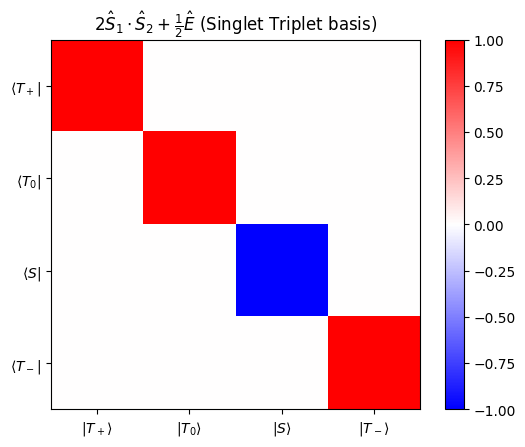

In [5]:
# Clear nuclei temporally
_nuclei_tmp0 = sim.molecules[0].nuclei
_nuclei_tmp1 = sim.molecules[1].nuclei
sim.molecules[0].nuclei = []
sim.molecules[1].nuclei = []

# for Singlet-Triplet basis
sx_1 = sim.spin_operator(0, "x")
sy_1 = sim.spin_operator(0, "y").imag  # <== Caution!
sz_1 = sim.spin_operator(0, "z")
sx_2 = sim.spin_operator(1, "x")
sy_2 = sim.spin_operator(1, "y").imag  # <== Caution!
sz_2 = sim.spin_operator(1, "z")

# Revert nuclei
sim.molecules[0].nuclei = _nuclei_tmp0
sim.molecules[1].nuclei = _nuclei_tmp1

plt.imshow(
    2 * (sx_1 @ sx_2 - sy_1 @ sy_2 + sz_1 @ sz_2).real
    + 0.5 * np.eye(*sx_1.shape),
    cmap="bwr",
    vmin=-1.0,
    vmax=1.0,
)
plt.title(
    r"$2\hat{S}_1\cdot \hat{S}_2 + \frac{1}{2}\hat{E}$ (Singlet Triplet basis)"
)
plt.colorbar()
plt.xticks(
    [0, 1, 2, 3],
    [r"$|T_+\rangle$", r"$|T_0\rangle$", r"$|S\rangle$", r"$|T_-\rangle$"],
)
plt.yticks(
    [0, 1, 2, 3],
    [
        r"$\langle T_+|$",
        r"$\langle T_0 |$",
        r"$\langle S|$",
        r"$\langle T_- |$",
    ],
)
plt.show()

## Define `OpSite` and coefficients

- RadicalPy uses Hz in energy unit but it is too large to keep numerical stabiltiy
- Thus, one will use GHz in energy unit
- For some reasons, extraction of imaginary unit of pauli y operator leads stable simulation for degenerate system (why??)

In [6]:
SCALE = 1.0e-09
gamma = [p.gamma_mT for p in sim.particles]

g_ele_sym = [
    Symbol(r"\gamma_e^{(" + f"{i + 1}" + ")}") for i in range(len(sim.radicals))
]
g_nuc_sym = {}
for i in range(len(sim.radicals)):
    for j in range(len(sim.molecules[i].nuclei)):
        g_nuc_sym[(i, j)] = Symbol(r"\gamma_n^{" + f"{(i + 1, j + 1)}" + "}")

subs = {}
for i, ge in enumerate(g_ele_sym):
    subs[ge] = sim.radicals[i].gamma_mT
for (i, j), gn in g_nuc_sym.items():
    subs[gn] = sim.molecules[i].nuclei[j].gamma_mT

Define radical spin operators

In [7]:
ele_site = len(sim.molecules[0].nuclei)

Sx_ops = []
Sy_ops = []
Sz_ops = []

S1S2_op = OpSite(
    r"\hat{S}_1\cdot\hat{S}_2",
    ele_site,
    value=(sx_1 @ sx_2 - sy_1 @ sy_2 + sz_1 @ sz_2).real,
)
E_op = OpSite(r"\hat{E}", ele_site, value=np.eye(*sx_1.shape))

Sx_ops.append(OpSite(r"\hat{S}_x^{(1)}", ele_site, value=sx_1))
Sy_ops.append(OpSite(r"\hat{S}_y^{(1)}", ele_site, value=sy_1))
Sz_ops.append(OpSite(r"\hat{S}_z^{(1)}", ele_site, value=sz_1))
Sx_ops.append(OpSite(r"\hat{S}_x^{(2)}", ele_site, value=sx_2))
Sy_ops.append(OpSite(r"\hat{S}_y^{(2)}", ele_site, value=sy_2))
Sz_ops.append(OpSite(r"\hat{S}_z^{(2)}", ele_site, value=sz_2))

Sr_ops = [Sx_ops, Sy_ops, Sz_ops]

Define nuclear spin operators

In [8]:
Ix_ops = {}
Iy_ops = {}
Iz_ops = {}

for j, nuc in enumerate(sim.molecules[0].nuclei):
    Ix_ops[(0, j)] = OpSite(
        r"\hat{I}_x^{" + f"{(1, j + 1)}" + "}", j, value=nuc.pauli["x"]
    )
    Iy_ops[(0, j)] = OpSite(
        r"\hat{I}_y^{" + f"{(1, j + 1)}" + "}", j, value=nuc.pauli["y"].imag
    )
    Iz_ops[(0, j)] = OpSite(
        r"\hat{I}_z^{" + f"{(1, j + 1)}" + "}", j, value=nuc.pauli["z"]
    )

for j, nuc in enumerate(sim.molecules[1].nuclei):
    Ix_ops[(1, j)] = OpSite(
        r"\hat{I}_x^{" + f"{(2, j + 1)}" + "}",
        ele_site + 1 + j,
        value=nuc.pauli["x"],
    )
    Iy_ops[(1, j)] = OpSite(
        r"\hat{I}_y^{" + f"{(2, j + 1)}" + "}",
        ele_site + 1 + j,
        value=nuc.pauli["y"].imag,
    )
    Iz_ops[(1, j)] = OpSite(
        r"\hat{I}_z^{" + f"{(2, j + 1)}" + "}",
        ele_site + 1 + j,
        value=nuc.pauli["z"],
    )

Ir_ops = [Ix_ops, Iy_ops, Iz_ops]

## Hyperfine coupling Hamiltonian
$$
\hat{H}_{\text{H}} = \sum_i \sum_j \hat{S}_i\cdot A_{ij}\cdot \hat{I}_{ij}
= \sum_i \sum_j \sum_{r\in\{x, y, z\}} A_{ij}\hat{S}_{r}^{(i)}\hat{I}_{r}^{(ij)}
$$

In [9]:
hyperfine = SumOfProducts()

xyz = "xyz"

for i in range(len(sim.radicals)):
    for j in range(len(sim.molecules[i].nuclei)):
        for k, Sr_op in enumerate(Sr_ops):
            for l, Ir_op in enumerate(Ir_ops):
                if A[(i, j)][k, l] == 0.0:
                    continue
                Asym = Symbol(
                    "A^{"
                    + f"{(i + 1, j + 1)}"
                    + "}_{"
                    + f"{xyz[k]}"
                    + f"{xyz[l]}"
                    + "}"
                )
                subs[Asym] = A[(i, j)][k, l].item() * SCALE
                if k == l == 1:
                    hyperfine -= Asym * g_ele_sym[i] * Sr_op[i] * Ir_op[(i, j)]
                elif k != 1 and l != 1:
                    hyperfine += Asym * g_ele_sym[i] * Sr_op[i] * Ir_op[(i, j)]
                else:
                    hyperfine += (
                        1.0j * Asym * g_ele_sym[i] * Sr_op[i] * Ir_op[(i, j)]
                    )

In [10]:
hyperfine = hyperfine.simplify()
hyperfine.symbol

A^{(1, 1)}_{xx}*\gamma_e^{(1)}*\hat{I}_x^{(1, 1)}*\hat{S}_x^{(1)} + 1.0*I*A^{(1, 1)}_{xy}*\gamma_e^{(1)}*\hat{I}_y^{(1, 1)}*\hat{S}_x^{(1)} + A^{(1, 1)}_{xz}*\gamma_e^{(1)}*\hat{I}_z^{(1, 1)}*\hat{S}_x^{(1)} + 1.0*I*A^{(1, 1)}_{yx}*\gamma_e^{(1)}*\hat{I}_x^{(1, 1)}*\hat{S}_y^{(1)} - A^{(1, 1)}_{yy}*\gamma_e^{(1)}*\hat{I}_y^{(1, 1)}*\hat{S}_y^{(1)} + 1.0*I*A^{(1, 1)}_{yz}*\gamma_e^{(1)}*\hat{I}_z^{(1, 1)}*\hat{S}_y^{(1)} + A^{(1, 1)}_{zx}*\gamma_e^{(1)}*\hat{I}_x^{(1, 1)}*\hat{S}_z^{(1)} + 1.0*I*A^{(1, 1)}_{zy}*\gamma_e^{(1)}*\hat{I}_y^{(1, 1)}*\hat{S}_z^{(1)} + A^{(1, 1)}_{zz}*\gamma_e^{(1)}*\hat{I}_z^{(1, 1)}*\hat{S}_z^{(1)} + A^{(1, 10)}_{xx}*\gamma_e^{(1)}*\hat{I}_x^{(1, 10)}*\hat{S}_x^{(1)} + 1.0*I*A^{(1, 10)}_{xy}*\gamma_e^{(1)}*\hat{I}_y^{(1, 10)}*\hat{S}_x^{(1)} + A^{(1, 10)}_{xz}*\gamma_e^{(1)}*\hat{I}_z^{(1, 10)}*\hat{S}_x^{(1)} + 1.0*I*A^{(1, 10)}_{yx}*\gamma_e^{(1)}*\hat{I}_x^{(1, 10)}*\hat{S}_y^{(1)} - A^{(1, 10)}_{yy}*\gamma_e^{(1)}*\hat{I}_y^{(1, 10)}*\hat{S}_y^{(1)} + 1.

## Zeeman Hamiltonian
$$
\hat{H}_{\text{Z}}
= - \vec{B} \cdot \sum_i \left(\gamma_{\text{e}}\vec{S}^{(i)} + \left(\sum_j\gamma_{\text{n}}^{(ij)}\vec{I}^{(ij)}\right)\right)
$$

In [11]:
zeeman = SumOfProducts()

xyz = "xyz"

for k, (Sr_op, Ir_op) in enumerate(zip(Sr_ops, Ir_ops, strict=True)):
    if B[k] == 0.0:
        continue
    r = xyz[k]
    Br = Symbol(f"B_{r}")
    subs[Br] = B[k] * SCALE
    for i in range(len(sim.radicals)):
        if k == 1:
            zeeman += -1.0j * Br * g_ele_sym[i] * Sr_op[i]
        else:
            zeeman += -Br * g_ele_sym[i] * Sr_op[i]
        for j in range(len(sim.molecules[i].nuclei)):
            if k == 1:
                zeeman += -1.0j * Br * g_nuc_sym[(i, j)] * Ir_op[(i, j)]
            else:
                zeeman += -Br * g_nuc_sym[(i, j)] * Ir_op[(i, j)]

zeeman = zeeman.simplify()
zeeman.symbol

-B_z*\gamma_e^{(1)}*\hat{S}_z^{(1)} - B_z*\gamma_e^{(2)}*\hat{S}_z^{(2)} - B_z*\gamma_n^{(1, 1)}*\hat{I}_z^{(1, 1)} - B_z*\gamma_n^{(1, 10)}*\hat{I}_z^{(1, 10)} - B_z*\gamma_n^{(1, 11)}*\hat{I}_z^{(1, 11)} - B_z*\gamma_n^{(1, 12)}*\hat{I}_z^{(1, 12)} - B_z*\gamma_n^{(1, 13)}*\hat{I}_z^{(1, 13)} - B_z*\gamma_n^{(1, 14)}*\hat{I}_z^{(1, 14)} - B_z*\gamma_n^{(1, 15)}*\hat{I}_z^{(1, 15)} - B_z*\gamma_n^{(1, 16)}*\hat{I}_z^{(1, 16)} - B_z*\gamma_n^{(1, 2)}*\hat{I}_z^{(1, 2)} - B_z*\gamma_n^{(1, 3)}*\hat{I}_z^{(1, 3)} - B_z*\gamma_n^{(1, 4)}*\hat{I}_z^{(1, 4)} - B_z*\gamma_n^{(1, 5)}*\hat{I}_z^{(1, 5)} - B_z*\gamma_n^{(1, 6)}*\hat{I}_z^{(1, 6)} - B_z*\gamma_n^{(1, 7)}*\hat{I}_z^{(1, 7)} - B_z*\gamma_n^{(1, 8)}*\hat{I}_z^{(1, 8)} - B_z*\gamma_n^{(1, 9)}*\hat{I}_z^{(1, 9)} - B_z*\gamma_n^{(2, 1)}*\hat{I}_z^{(2, 1)} - B_z*\gamma_n^{(2, 10)}*\hat{I}_z^{(2, 10)} - B_z*\gamma_n^{(2, 11)}*\hat{I}_z^{(2, 11)} - B_z*\gamma_n^{(2, 2)}*\hat{I}_z^{(2, 2)} - B_z*\gamma_n^{(2, 3)}*\hat{I}_z^{(2, 3)} - B_z*

## Exchange Hamiltonian
$$
\hat{H}_{\text{J}}
= J \gamma_e \left(\vec{S}_1\cdot\vec{S_2}+\frac{1}{2}\hat{E}\right)
$$

In [12]:
exchange = SumOfProducts()
Jsym = Symbol("J")
subs[Jsym] = J * SCALE
exchange += Jsym * g_ele_sym[0] * (2 * S1S2_op + 0.5 * E_op)
exchange = exchange.simplify()
exchange.symbol

0.5*J*\gamma_e^{(1)}*\hat{E} + 2*J*\gamma_e^{(1)}*\hat{S}_1\cdot\hat{S}_2

## Dipolar Hamiltonian
$$
\hat{H}_{\text{J}}
= \vec{S}_1^\top \cdot D \cdot \vec{S_2}
$$

In [13]:
dipolar = SumOfProducts()
for k in range(3):
    for l in range(3):
        if D[k, l] == 0.0:
            continue
        else:
            Dsym = Symbol("D_{" + f"{xyz[k]}" + f"{xyz[l]}" + "}")
            subs[Dsym] = D[k, l] * SCALE
            if k == l == 1:
                dipolar += -Dsym * Sr_ops[k][0] * Sr_ops[l][1]
            elif k != 1 and l != 1:
                dipolar += Dsym * Sr_ops[k][0] * Sr_ops[l][1]
            else:
                dipolar += 1.0j * Dsym * Sr_ops[k][0] * Sr_ops[l][1]
dipolar = dipolar.simplify()
dipolar.symbol

D_{xx}*\hat{S}_x^{(1)}*\hat{S}_x^{(2)} + 1.0*I*D_{xy}*\hat{S}_x^{(1)}*\hat{S}_y^{(2)} + D_{xz}*\hat{S}_x^{(1)}*\hat{S}_z^{(2)} + 1.0*I*D_{yx}*\hat{S}_y^{(1)}*\hat{S}_x^{(2)} - D_{yy}*\hat{S}_y^{(1)}*\hat{S}_y^{(2)} + 1.0*I*D_{yz}*\hat{S}_y^{(1)}*\hat{S}_z^{(2)} + D_{zx}*\hat{S}_z^{(1)}*\hat{S}_x^{(2)} + 1.0*I*D_{zy}*\hat{S}_z^{(1)}*\hat{S}_y^{(2)} + D_{zz}*\hat{S}_z^{(1)}*\hat{S}_z^{(2)}

Construct matrix product operator (MPO) for MPS propagation

In [14]:
hamiltonian = hyperfine + zeeman + exchange + dipolar
hamiltonian = hamiltonian.simplify()
am = AssignManager(hamiltonian)
_ = am.assign()
# display(*am.Wsym)
mpo = am.numerical_mpo(subs=subs)

## Mixed state (ensemble) simulation

In [15]:
backend = "numpy"
m = 32  # Bond dimension
Δt = 5.0e-10 / SCALE * units.au_in_fs  # dt = 0.5 ns

spin_coherent = True  # Whether or not use coherent state sampling

In [16]:
basis = []
for nuc in sim.molecules[0].nuclei:
    basis.append(Exciton(nstate=nuc.multiplicity))
basis.append(Exciton(nstate=4))
for nuc in sim.molecules[1].nuclei:
    basis.append(Exciton(nstate=nuc.multiplicity))
basinfo = BasInfo([basis], spf_info=None)

nsite = len(basis)

In [17]:
op_dict = {
    tuple([(isite, isite) for isite in range(nsite)]): TensorOperator(mpo=mpo)
}
H = TensorHamiltonian(
    nsite, potential=[[op_dict]], kinetic=None, backend=backend
)

In [18]:
def spin_coherenet_state(pair):
    """
    J. Chem. Phys. 154, 084121 (2021); doi: 10.1063/5.0040519

    Sample from spin coherent state
    |Ω⁽ᴵ⁾⟩ = cos(θ/2)²ᴵ exp(tan(θ/2)exp(iϕ)Î₋) |I,I⟩
    """
    hp = []
    for isite in range(nsite):
        if isite == ele_site:
            hp.append([0, 0, 1, 0])  # Singlet
        else:
            mult = basis[isite].nstate
            I = (mult - 1) / 2
            nind = isite - int(ele_site <= isite)

            theta = np.arccos(pair[2 * nind] * 2 - 1.0)
            # same as
            # theta = np.arcsin(pair[2*nind] * 2 - 1.0)
            # if theta < 0:
            #    theta += np.pi
            phi = pair[2 * nind + 1] * 2 * np.pi
            weights = np.zeros((mult, 1))
            weights[0, 0] = 1.0
            weights = (
                (np.cos(theta / 2) ** (2 * I))
                * expm(
                    np.tan(theta / 2)
                    * np.exp(1.0j * phi)
                    * sim.nuclei[nind].pauli["m"]
                )
                @ weights
            )
            assert (
                abs((weights.conjugate().T @ weights).real[0, 0] - 1.0)
                < 1.0e-14
            ), (weights.conjugate().T @ weights)[0, 0]
            # print(weights.conjugate().T @ weights, weights)
            hp.append(weights.reshape(-1).tolist())
    return hp


def projection_state(pair):
    """
    Sampel from projection state |M⟩
    """
    init_nuc_spins = [
        np.floor(pair[i] * basis[i + int(ele_site <= i)].nstate).astype(int)
        for i in range(nsite - 1)
    ]
    hp = []
    for isite in range(nsite):
        if isite == ele_site:
            hp.append([0, 0, 1, 0])  # Singlet
        else:
            weights = np.zeros(basis[isite].nstate)
            weights[init_nuc_spins[isite - int(ele_site <= isite)]] = 1.0
            hp.append(weights.tolist())
    return hp


def process_pair(pair, i, H):
    operators = {"hamiltonian": H}
    model = Model(basinfo=basinfo, operators=operators)
    model.m_aux_max = m
    if spin_coherent:
        hp = spin_coherenet_state(pair)
    else:
        hp = projection_state(pair)
    model.init_HartreeProduct = [hp]

    jobname = f"radicalpair_{i}"
    simulator = Simulator(
        jobname=jobname, model=model, backend=backend, verbose=0
    )
    ener, wf = simulator.propagate(
        reduced_density=(
            [(ele_site, ele_site)],
            2,
        ),
        maxstep=100,
        stepsize=Δt,
        autocorr=False,
        energy=False,
        norm=False,
        populations=False,
    )

    with nc.Dataset(f"{jobname}_prop/reduced_density.nc", "r") as file:
        density_data_real = file.variables[f"rho_({ele_site}, {ele_site})_0"][
            :
        ]["real"]
        density_data_imag = file.variables[f"rho_({ele_site}, {ele_site})_0"][
            :
        ]["imag"]
        time_data = file.variables["time"][:]

    density_data = np.array(density_data_real) + 1.0j * np.array(
        density_data_imag
    )
    time_data = np.array(time_data)

    return density_data, time_data

Since nuclear spins are mixed state, one needs to consider ensemble of nuclear spin initial states. 
The calculation is performed in parallel for each trajectory.
When the number of nuclear spins large, switch to quasi Monte Carlo approach. 

In [19]:
futures = []
density_sum = None

# If number of nuclear spin is larger than 6,
# initial states are randomly sampled by quasi Monte Carlo
is_mc = len(basis) - 1 > 5

if spin_coherent:
    engine = qmc.Sobol(d=2 * (nsite - 1), scramble=True)
else:
    engine = qmc.Sobol(d=nsite - 1, scramble=True)
pairs = engine.random(n=2**7)  # sample from [0, 1]^N hypercubic

In [20]:
density_sums = []
# execute `max_workers` process in parallel
max_workers = 8
with ProcessPoolExecutor(max_workers=max_workers) as executor:
    try:
        density_sum = None
        active_futures = []
        i = 0  # number of submitted jobs
        j = 0  # number of finished jobs

        pbar = tqdm(total=len(pairs), desc="Processing pairs")
        while i < len(pairs) or active_futures:
            # Submit new jobs up to max_active
            while len(active_futures) < max_workers and i < len(pairs):
                future = executor.submit(process_pair, pairs[i], i, H)
                active_futures.append((future, i))
                i += 1

            # Wait for at least one job to complete
            done, not_done = concurrent.futures.wait(
                [f for f, _ in active_futures],
                return_when=concurrent.futures.FIRST_COMPLETED,
            )

            # Process completed jobs
            remaining_futures = []
            for future, job_i in active_futures:
                if future in done:
                    density_data, time_data = future.result()
                    if density_sum is None:
                        density_sum = density_data
                    else:
                        density_sum += density_data
                    j += 1
                    if is_mc and j >= 32 and j.bit_count() == 1:
                        # when j in [4, 8, 16, ...] record result to estimate convergence of Monte Carlo
                        density_sums.append(density_sum / j)
                    pbar.update(1)
                else:
                    remaining_futures.append((future, job_i))
            active_futures = remaining_futures

    except KeyboardInterrupt:
        print("\nCancelling active tasks...")
        for future, _ in active_futures:
            future.cancel()
        executor.shutdown(wait=False)
        pbar.close()
        raise

    pbar.close()

Processing pairs:   0%|          | 0/128 [00:00<?, ?it/s]

16:41:43 | INFO | Wave function is saved in wf_radicalpair_5.pkl
16:41:43 | INFO | Wave function is saved in wf_radicalpair_1.pkl
16:41:43 | INFO | Wave function is saved in wf_radicalpair_6.pkl
16:41:43 | INFO | Wave function is saved in wf_radicalpair_0.pkl
16:41:43 | INFO | Wave function is saved in wf_radicalpair_7.pkl
16:41:43 | INFO | Wave function is saved in wf_radicalpair_3.pkl
16:41:43 | INFO | Wave function is saved in wf_radicalpair_4.pkl
16:41:43 | INFO | Wave function is saved in wf_radicalpair_2.pkl
16:41:43 | INFO | Start initial step    0.000 [fs]
16:41:43 | INFO | Start initial step    0.000 [fs]
16:41:43 | INFO | Start initial step    0.000 [fs]
16:41:43 | INFO | Start initial step    0.000 [fs]
16:41:43 | INFO | Start initial step    0.000 [fs]
16:41:43 | INFO | Start initial step    0.000 [fs]
16:41:43 | INFO | Start initial step    0.000 [fs]
16:41:43 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

16:41:44 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:41:44 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:41:44 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:41:44 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.04
16:41:44 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.11
16:41:44 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:41:44 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.75
16:41:44 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.54
16:42:14 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:42:14 | INFO | End simulation and save wavefunction
16:42:14 | INFO | Wave function is saved in wf_radicalpair_4.pkl
16:42:15 | INFO | Wave function is saved in wf_radicalpair_8.pkl
16:42:15 | INFO | Start initial 

  0%|          | 0/100 [00:00<?, ?it/s]

16:42:15 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:42:15 | INFO | End simulation and save wavefunction
16:42:15 | INFO | Wave function is saved in wf_radicalpair_2.pkl
16:42:15 | INFO | Wave function is saved in wf_radicalpair_9.pkl
16:42:15 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:15 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:42:15 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:42:15 | INFO | End simulation and save wavefunction
16:42:15 | INFO | Wave function is saved in wf_radicalpair_0.pkl
16:42:15 | INFO | Wave function is saved in wf_radicalpair_10.pkl
16:42:15 | INFO | Start initial step    0.000 [fs]
16:42:15 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.93
16:42:15 | INFO | End simulation and save wavefunction


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:15 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.21
16:42:15 | INFO | Wave function is saved in wf_radicalpair_3.pkl
16:42:15 | INFO | Wave function is saved in wf_radicalpair_11.pkl
16:42:15 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:15 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.46
16:42:15 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:42:16 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.96
16:42:16 | INFO | End simulation and save wavefunction
16:42:16 | INFO | Wave function is saved in wf_radicalpair_1.pkl
16:42:16 | INFO | Wave function is saved in wf_radicalpair_12.pkl
16:42:16 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:17 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.25
16:42:17 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.32
16:42:17 | INFO | End simulation and save wavefunction
16:42:17 | INFO | Wave function is saved in wf_radicalpair_7.pkl
16:42:17 | INFO | Wave function is saved in wf_radicalpair_13.pkl
16:42:17 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:17 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.46
16:42:17 | INFO | End simulation and save wavefunction
16:42:17 | INFO | Wave function is saved in wf_radicalpair_6.pkl
16:42:17 | INFO | Wave function is saved in wf_radicalpair_14.pkl
16:42:17 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:17 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.79
16:42:17 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.43
16:42:17 | INFO | End simulation and save wavefunction
16:42:17 | INFO | Wave function is saved in wf_radicalpair_5.pkl
16:42:17 | INFO | Wave function is saved in wf_radicalpair_15.pkl
16:42:17 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:17 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:42:18 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:42:46 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:42:46 | INFO | End simulation and save wavefunction
16:42:46 | INFO | Wave function is saved in wf_radicalpair_8.pkl
16:42:46 | INFO | Wave function is saved in wf_radicalpair_16.pkl
16:42:46 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:46 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:42:46 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.86
16:42:46 | INFO | End simulation and save wavefunction
16:42:46 | INFO | Wave function is saved in wf_radicalpair_11.pkl
16:42:46 | INFO | Wave function is saved in wf_radicalpair_17.pkl
16:42:46 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:47 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.00
16:42:47 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.93
16:42:47 | INFO | End simulation and save wavefunction
16:42:47 | INFO | Wave function is saved in wf_radicalpair_9.pkl
16:42:47 | INFO | Wave function is saved in wf_radicalpair_18.pkl
16:42:47 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:47 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:42:48 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.29
16:42:48 | INFO | End simulation and save wavefunction
16:42:48 | INFO | Wave function is saved in wf_radicalpair_10.pkl
16:42:48 | INFO | Wave function is saved in wf_radicalpair_19.pkl
16:42:48 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:48 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.86
16:42:48 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:42:48 | INFO | End simulation and save wavefunction
16:42:48 | INFO | Wave function is saved in wf_radicalpair_15.pkl
16:42:48 | INFO | Wave function is saved in wf_radicalpair_20.pkl
16:42:48 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:48 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.32
16:42:48 | INFO | End simulation and save wavefunction
16:42:48 | INFO | Wave function is saved in wf_radicalpair_12.pkl
16:42:48 | INFO | Wave function is saved in wf_radicalpair_21.pkl
16:42:48 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:49 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.86
16:42:49 | INFO | End simulation and save wavefunction
16:42:49 | INFO | Wave function is saved in wf_radicalpair_14.pkl
16:42:49 | INFO | Wave function is saved in wf_radicalpair_22.pkl
16:42:49 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:49 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.39
16:42:49 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.25
16:42:49 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.54
16:42:50 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.71
16:42:50 | INFO | End simulation and save wavefunction
16:42:50 | INFO | Wave function is saved in wf_radicalpair_13.pkl
16:42:50 | INFO | Wave function is saved in wf_radicalpair_23.pkl
16:42:50 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:42:51 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:43:17 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:43:17 | INFO | End simulation and save wavefunction
16:43:17 | INFO | Wave function is saved in wf_radicalpair_16.pkl
16:43:17 | INFO | Wave function is saved in wf_radicalpair_24.pkl
16:43:17 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:17 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:43:18 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.89
16:43:18 | INFO | End simulation and save wavefunction
16:43:18 | INFO | Wave function is saved in wf_radicalpair_18.pkl
16:43:18 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.86
16:43:18 | INFO | End simulation and save wavefunction
16:43:18 | INFO | Wave function is saved in wf_radicalpair_25.pkl
16:43:18 | INFO | Start initial step    0.000 [fs]
16:43:18 | INFO | Wave function is saved in wf_radicalpair_17.pkl


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:18 | INFO | Wave function is saved in wf_radicalpair_26.pkl
16:43:18 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:19 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.32
16:43:19 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.89
16:43:19 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:43:19 | INFO | End simulation and save wavefunction
16:43:19 | INFO | Wave function is saved in wf_radicalpair_19.pkl
16:43:19 | INFO | Wave function is saved in wf_radicalpair_27.pkl
16:43:19 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:19 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:43:21 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.11
16:43:21 | INFO | End simulation and save wavefunction
16:43:21 | INFO | Wave function is saved in wf_radicalpair_21.pkl
16:43:21 | INFO | Wave function is saved in wf_radicalpair_28.pkl
16:43:21 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:21 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.25
16:43:21 | INFO | End simulation and save wavefunction
16:43:21 | INFO | Wave function is saved in wf_radicalpair_20.pkl
16:43:21 | INFO | Wave function is saved in wf_radicalpair_29.pkl
16:43:21 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:21 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.82
16:43:21 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.86
16:43:21 | INFO | End simulation and save wavefunction
16:43:21 | INFO | Wave function is saved in wf_radicalpair_23.pkl
16:43:21 | INFO | Wave function is saved in wf_radicalpair_30.pkl
16:43:21 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:21 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.79
16:43:22 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:43:22 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.21
16:43:22 | INFO | End simulation and save wavefunction
16:43:22 | INFO | Wave function is saved in wf_radicalpair_22.pkl
16:43:22 | INFO | Wave function is saved in wf_radicalpair_31.pkl
16:43:22 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:22 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:43:50 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.86
16:43:50 | INFO | End simulation and save wavefunction
16:43:50 | INFO | Wave function is saved in wf_radicalpair_24.pkl
16:43:50 | INFO | Wave function is saved in wf_radicalpair_32.pkl
16:43:50 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:51 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.86
16:43:53 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.75
16:43:53 | INFO | End simulation and save wavefunction
16:43:53 | INFO | Wave function is saved in wf_radicalpair_26.pkl
16:43:53 | INFO | Wave function is saved in wf_radicalpair_33.pkl
16:43:53 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:53 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:43:53 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:43:53 | INFO | End simulation and save wavefunction
16:43:53 | INFO | Wave function is saved in wf_radicalpair_27.pkl
16:43:53 | INFO | Wave function is saved in wf_radicalpair_34.pkl
16:43:53 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:54 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.18
16:43:54 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.18
16:43:54 | INFO | End simulation and save wavefunction
16:43:54 | INFO | Wave function is saved in wf_radicalpair_25.pkl
16:43:54 | INFO | Wave function is saved in wf_radicalpair_35.pkl
16:43:54 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:55 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.54
16:43:56 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:43:56 | INFO | End simulation and save wavefunction
16:43:56 | INFO | Wave function is saved in wf_radicalpair_30.pkl
16:43:56 | INFO | Wave function is saved in wf_radicalpair_36.pkl
16:43:56 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:56 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.86
16:43:56 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.75
16:43:56 | INFO | End simulation and save wavefunction
16:43:56 | INFO | Wave function is saved in wf_radicalpair_31.pkl
16:43:57 | INFO | Wave function is saved in wf_radicalpair_37.pkl
16:43:57 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:57 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:43:58 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.46
16:43:58 | INFO | End simulation and save wavefunction
16:43:58 | INFO | Wave function is saved in wf_radicalpair_29.pkl
16:43:58 | INFO | Wave function is saved in wf_radicalpair_38.pkl
16:43:58 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:58 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.68
16:43:58 | INFO | End simulation and save wavefunction
16:43:58 | INFO | Wave function is saved in wf_radicalpair_28.pkl
16:43:58 | INFO | Wave function is saved in wf_radicalpair_39.pkl
16:43:58 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:43:58 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:43:58 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.96
16:44:23 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.71
16:44:23 | INFO | End simulation and save wavefunction
16:44:23 | INFO | Wave function is saved in wf_radicalpair_32.pkl
16:44:23 | INFO | Wave function is saved in wf_radicalpair_40.pkl
16:44:23 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:44:23 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:44:26 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.75
16:44:26 | INFO | End simulation and save wavefunction
16:44:26 | INFO | Wave function is saved in wf_radicalpair_33.pkl
16:44:26 | INFO | Wave function is saved in wf_radicalpair_41.pkl
16:44:26 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:44:26 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.54
16:44:26 | INFO | End simulation and save wavefunction
16:44:26 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.86
16:44:26 | INFO | Wave function is saved in wf_radicalpair_35.pkl
16:44:26 | INFO | Wave function is saved in wf_radicalpair_42.pkl
16:44:26 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:44:26 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.25
16:44:28 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.07
16:44:28 | INFO | End simulation and save wavefunction
16:44:28 | INFO | Wave function is saved in wf_radicalpair_34.pkl
16:44:28 | INFO | Wave function is saved in wf_radicalpair_43.pkl
16:44:28 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:44:28 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:44:29 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.71
16:44:29 | INFO | End simulation and save wavefunction
16:44:29 | INFO | Wave function is saved in wf_radicalpair_36.pkl
16:44:29 | INFO | Wave function is saved in wf_radicalpair_44.pkl
16:44:29 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:44:29 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.71
16:44:29 | INFO | End simulation and save wavefunction
16:44:29 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:44:29 | INFO | Wave function is saved in wf_radicalpair_37.pkl
16:44:29 | INFO | Wave function is saved in wf_radicalpair_45.pkl
16:44:29 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:44:30 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.82
16:44:31 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.89
16:44:31 | INFO | End simulation and save wavefunction
16:44:31 | INFO | Wave function is saved in wf_radicalpair_38.pkl
16:44:31 | INFO | Wave function is saved in wf_radicalpair_46.pkl
16:44:31 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:44:31 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.71
16:44:31 | INFO | End simulation and save wavefunction
16:44:31 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:44:31 | INFO | Wave function is saved in wf_radicalpair_39.pkl
16:44:31 | INFO | Wave function is saved in wf_radicalpair_47.pkl
16:44:31 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:44:32 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:44:58 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.75
16:44:58 | INFO | End simulation and save wavefunction
16:44:58 | INFO | Wave function is saved in wf_radicalpair_40.pkl
16:44:58 | INFO | Wave function is saved in wf_radicalpair_48.pkl
16:44:58 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:44:58 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:45:00 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.75
16:45:00 | INFO | End simulation and save wavefunction
16:45:00 | INFO | Wave function is saved in wf_radicalpair_41.pkl
16:45:01 | INFO | Wave function is saved in wf_radicalpair_49.pkl
16:45:01 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:01 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.18
16:45:02 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.04
16:45:02 | INFO | End simulation and save wavefunction
16:45:02 | INFO | Wave function is saved in wf_radicalpair_42.pkl
16:45:02 | INFO | Wave function is saved in wf_radicalpair_50.pkl
16:45:02 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:02 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.86
16:45:02 | INFO | End simulation and save wavefunction
16:45:02 | INFO | Wave function is saved in wf_radicalpair_43.pkl
16:45:02 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.71
16:45:02 | INFO | Wave function is saved in wf_radicalpair_51.pkl
16:45:02 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:03 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.86
16:45:03 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:45:03 | INFO | End simulation and save wavefunction
16:45:03 | INFO | Wave function is saved in wf_radicalpair_44.pkl
16:45:03 | INFO | Wave function is saved in wf_radicalpair_52.pkl
16:45:03 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:03 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.82
16:45:05 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.75
16:45:05 | INFO | End simulation and save wavefunction
16:45:05 | INFO | Wave function is saved in wf_radicalpair_46.pkl
16:45:05 | INFO | Wave function is saved in wf_radicalpair_53.pkl
16:45:05 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:05 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.25
16:45:05 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:45:05 | INFO | End simulation and save wavefunction
16:45:05 | INFO | Wave function is saved in wf_radicalpair_47.pkl
16:45:05 | INFO | Wave function is saved in wf_radicalpair_54.pkl
16:45:05 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:06 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.36
16:45:06 | INFO | End simulation and save wavefunction
16:45:06 | INFO | Wave function is saved in wf_radicalpair_45.pkl
16:45:06 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.04
16:45:06 | INFO | Wave function is saved in wf_radicalpair_55.pkl
16:45:06 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:06 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:45:32 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:45:32 | INFO | End simulation and save wavefunction
16:45:32 | INFO | Wave function is saved in wf_radicalpair_48.pkl
16:45:32 | INFO | Wave function is saved in wf_radicalpair_56.pkl
16:45:32 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:32 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.00
16:45:36 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.04
16:45:36 | INFO | End simulation and save wavefunction
16:45:36 | INFO | Wave function is saved in wf_radicalpair_49.pkl
16:45:36 | INFO | Wave function is saved in wf_radicalpair_57.pkl
16:45:36 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:36 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:45:36 | INFO | End simulation and save wavefunction
16:45:36 | INFO | Wave function is saved in wf_radicalpair_51.pkl
16:45:36 | INFO | Wave function is saved in wf_radicalpair_58.pkl
16:45:36 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:37 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.79
16:45:37 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.68
16:45:37 | INFO | End simulation and save wavefunction
16:45:37 | INFO | Wave function is saved in wf_radicalpair_52.pkl
16:45:37 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.43
16:45:37 | INFO | Wave function is saved in wf_radicalpair_59.pkl
16:45:37 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:37 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:45:38 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.18
16:45:38 | INFO | End simulation and save wavefunction
16:45:38 | INFO | Wave function is saved in wf_radicalpair_50.pkl
16:45:38 | INFO | Wave function is saved in wf_radicalpair_60.pkl
16:45:38 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:38 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.86
16:45:40 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:45:40 | INFO | End simulation and save wavefunction
16:45:40 | INFO | Wave function is saved in wf_radicalpair_55.pkl
16:45:40 | INFO | Wave function is saved in wf_radicalpair_61.pkl
16:45:40 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:40 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.11
16:45:40 | INFO | End simulation and save wavefunction
16:45:40 | INFO | Wave function is saved in wf_radicalpair_53.pkl
16:45:40 | INFO | Wave function is saved in wf_radicalpair_62.pkl
16:45:40 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:40 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.00
16:45:40 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.96
16:45:40 | INFO | End simulation and save wavefunction
16:45:40 | INFO | Wave function is saved in wf_radicalpair_54.pkl
16:45:41 | INFO | Wave function is saved in wf_radicalpair_63.pkl
16:45:41 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:45:41 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.11
16:45:41 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:46:07 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.04
16:46:07 | INFO | End simulation and save wavefunction
16:46:07 | INFO | Wave function is saved in wf_radicalpair_56.pkl
16:46:07 | INFO | Wave function is saved in wf_radicalpair_64.pkl
16:46:07 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:07 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:46:11 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:46:11 | INFO | End simulation and save wavefunction
16:46:11 | INFO | Wave function is saved in wf_radicalpair_59.pkl
16:46:11 | INFO | Wave function is saved in wf_radicalpair_65.pkl
16:46:11 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:11 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.04
16:46:12 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.68
16:46:12 | INFO | End simulation and save wavefunction
16:46:12 | INFO | Wave function is saved in wf_radicalpair_60.pkl
16:46:12 | INFO | Wave function is saved in wf_radicalpair_66.pkl
16:46:12 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:12 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.29
16:46:12 | INFO | End simulation and save wavefunction
16:46:12 | INFO | Wave function is saved in wf_radicalpair_58.pkl
16:46:12 | INFO | Wave function is saved in wf_radicalpair_67.pkl
16:46:12 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:12 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.21
16:46:12 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.64
16:46:12 | INFO | End simulation and save wavefunction
16:46:12 | INFO | Wave function is saved in wf_radicalpair_57.pkl
16:46:12 | INFO | Wave function is saved in wf_radicalpair_68.pkl
16:46:12 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:12 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.54
16:46:13 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.86
16:46:14 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:46:14 | INFO | End simulation and save wavefunction
16:46:14 | INFO | Wave function is saved in wf_radicalpair_61.pkl
16:46:15 | INFO | Wave function is saved in wf_radicalpair_69.pkl
16:46:15 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:15 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:46:15 | INFO | End simulation and save wavefunction
16:46:15 | INFO | Wave function is saved in wf_radicalpair_63.pkl
16:46:15 | INFO | Wave function is saved in wf_radicalpair_70.pkl
16:46:15 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:15 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.14
16:46:15 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.75
16:46:16 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.04
16:46:16 | INFO | End simulation and save wavefunction
16:46:16 | INFO | Wave function is saved in wf_radicalpair_62.pkl
16:46:16 | INFO | Wave function is saved in wf_radicalpair_71.pkl
16:46:16 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:16 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.04
16:46:42 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.86
16:46:42 | INFO | End simulation and save wavefunction
16:46:42 | INFO | Wave function is saved in wf_radicalpair_64.pkl
16:46:42 | INFO | Wave function is saved in wf_radicalpair_72.pkl
16:46:42 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:43 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:46:48 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:46:48 | INFO | End simulation and save wavefunction
16:46:48 | INFO | Wave function is saved in wf_radicalpair_68.pkl
16:46:48 | INFO | Wave function is saved in wf_radicalpair_73.pkl
16:46:48 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:48 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.00
16:46:48 | INFO | End simulation and save wavefunction
16:46:48 | INFO | Wave function is saved in wf_radicalpair_65.pkl
16:46:48 | INFO | Wave function is saved in wf_radicalpair_74.pkl
16:46:48 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:48 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:46:48 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.00
16:46:49 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.04
16:46:49 | INFO | End simulation and save wavefunction
16:46:49 | INFO | Wave function is saved in wf_radicalpair_66.pkl
16:46:49 | INFO | Wave function is saved in wf_radicalpair_75.pkl
16:46:49 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:50 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:46:50 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.46
16:46:50 | INFO | End simulation and save wavefunction
16:46:50 | INFO | Wave function is saved in wf_radicalpair_67.pkl
16:46:50 | INFO | Wave function is saved in wf_radicalpair_76.pkl
16:46:50 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:50 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:46:51 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.00
16:46:51 | INFO | End simulation and save wavefunction
16:46:51 | INFO | Wave function is saved in wf_radicalpair_69.pkl
16:46:51 | INFO | Wave function is saved in wf_radicalpair_77.pkl
16:46:51 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:52 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:46:53 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.18
16:46:53 | INFO | End simulation and save wavefunction
16:46:53 | INFO | Wave function is saved in wf_radicalpair_70.pkl
16:46:53 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.04
16:46:53 | INFO | End simulation and save wavefunction
16:46:53 | INFO | Wave function is saved in wf_radicalpair_71.pkl
16:46:53 | INFO | Wave function is saved in wf_radicalpair_78.pkl
16:46:53 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:53 | INFO | Wave function is saved in wf_radicalpair_79.pkl
16:46:53 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:46:53 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.86
16:46:53 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.96
16:47:16 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:47:16 | INFO | End simulation and save wavefunction
16:47:16 | INFO | Wave function is saved in wf_radicalpair_72.pkl
16:47:16 | INFO | Wave function is saved in wf_radicalpair_80.pkl
16:47:16 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:16 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.00
16:47:21 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:47:21 | INFO | End simulation and save wavefunction
16:47:21 | INFO | Wave function is saved in wf_radicalpair_74.pkl
16:47:21 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:47:21 | INFO | End simulation and save wavefunction
16:47:21 | INFO | Wave function is saved in wf_radicalpair_81.pkl
16:47:21 | INFO | Start initial step    0.000 [fs]
16:47:21 | INFO | Wave function is saved in wf_radicalpair_73.pkl


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:21 | INFO | Wave function is saved in wf_radicalpair_82.pkl
16:47:21 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:22 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.68
16:47:22 | INFO | End simulation and save wavefunction
16:47:22 | INFO | Wave function is saved in wf_radicalpair_75.pkl
16:47:22 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:47:22 | INFO | Wave function is saved in wf_radicalpair_83.pkl
16:47:22 | INFO | Start initial step    0.000 [fs]
16:47:22 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:22 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.00
16:47:23 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.86
16:47:23 | INFO | End simulation and save wavefunction
16:47:23 | INFO | Wave function is saved in wf_radicalpair_76.pkl
16:47:23 | INFO | Wave function is saved in wf_radicalpair_84.pkl
16:47:23 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:23 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.75
16:47:24 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.93
16:47:24 | INFO | End simulation and save wavefunction
16:47:24 | INFO | Wave function is saved in wf_radicalpair_77.pkl
16:47:24 | INFO | Wave function is saved in wf_radicalpair_85.pkl
16:47:24 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:25 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.75
16:47:25 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.75
16:47:25 | INFO | End simulation and save wavefunction
16:47:25 | INFO | Wave function is saved in wf_radicalpair_78.pkl
16:47:25 | INFO | Wave function is saved in wf_radicalpair_86.pkl
16:47:25 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:25 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.00
16:47:26 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.07
16:47:26 | INFO | End simulation and save wavefunction
16:47:26 | INFO | Wave function is saved in wf_radicalpair_79.pkl
16:47:26 | INFO | Wave function is saved in wf_radicalpair_87.pkl
16:47:26 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:27 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:47:49 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.04
16:47:49 | INFO | End simulation and save wavefunction
16:47:49 | INFO | Wave function is saved in wf_radicalpair_80.pkl
16:47:49 | INFO | Wave function is saved in wf_radicalpair_88.pkl
16:47:49 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:49 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:47:53 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.86
16:47:53 | INFO | End simulation and save wavefunction
16:47:53 | INFO | Wave function is saved in wf_radicalpair_82.pkl
16:47:53 | INFO | Wave function is saved in wf_radicalpair_89.pkl
16:47:53 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:53 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.11
16:47:53 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:47:53 | INFO | End simulation and save wavefunction
16:47:53 | INFO | Wave function is saved in wf_radicalpair_81.pkl
16:47:53 | INFO | Wave function is saved in wf_radicalpair_90.pkl
16:47:53 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:54 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.00
16:47:54 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.86
16:47:54 | INFO | End simulation and save wavefunction
16:47:54 | INFO | Wave function is saved in wf_radicalpair_83.pkl
16:47:54 | INFO | Wave function is saved in wf_radicalpair_91.pkl
16:47:54 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:54 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.18
16:47:57 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.46
16:47:57 | INFO | End simulation and save wavefunction
16:47:57 | INFO | Wave function is saved in wf_radicalpair_84.pkl
16:47:57 | INFO | Wave function is saved in wf_radicalpair_92.pkl
16:47:57 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:58 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.89
16:47:58 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.04
16:47:58 | INFO | End simulation and save wavefunction
16:47:58 | INFO | Wave function is saved in wf_radicalpair_86.pkl
16:47:58 | INFO | Wave function is saved in wf_radicalpair_93.pkl
16:47:58 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:59 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.43
16:47:59 | INFO | End simulation and save wavefunction
16:47:59 | INFO | Wave function is saved in wf_radicalpair_85.pkl
16:47:59 | INFO | Wave function is saved in wf_radicalpair_94.pkl
16:47:59 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:47:59 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.18
16:47:59 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:47:59 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.14
16:47:59 | INFO | End simulation and save wavefunction
16:47:59 | INFO | Wave function is saved in wf_radicalpair_87.pkl
16:48:00 | INFO | Wave function is saved in wf_radicalpair_95.pkl
16:48:00 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:48:00 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:48:21 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.71
16:48:21 | INFO | End simulation and save wavefunction
16:48:21 | INFO | Wave function is saved in wf_radicalpair_88.pkl
16:48:21 | INFO | Wave function is saved in wf_radicalpair_96.pkl
16:48:21 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:48:21 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.71
16:48:26 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.89
16:48:26 | INFO | End simulation and save wavefunction
16:48:26 | INFO | Wave function is saved in wf_radicalpair_90.pkl
16:48:26 | INFO | Wave function is saved in wf_radicalpair_97.pkl
16:48:26 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:48:26 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:48:26 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.00
16:48:26 | INFO | End simulation and save wavefunction
16:48:26 | INFO | Wave function is saved in wf_radicalpair_89.pkl
16:48:26 | INFO | Wave function is saved in wf_radicalpair_98.pkl
16:48:26 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:48:27 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.50
16:48:27 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.96
16:48:27 | INFO | End simulation and save wavefunction
16:48:27 | INFO | Wave function is saved in wf_radicalpair_91.pkl
16:48:27 | INFO | Wave function is saved in wf_radicalpair_99.pkl
16:48:27 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:48:27 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:48:31 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:48:31 | INFO | End simulation and save wavefunction
16:48:31 | INFO | Wave function is saved in wf_radicalpair_94.pkl
16:48:31 | INFO | Wave function is saved in wf_radicalpair_100.pkl
16:48:31 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:48:31 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.86
16:48:32 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:48:32 | INFO | End simulation and save wavefunction
16:48:32 | INFO | Wave function is saved in wf_radicalpair_95.pkl
16:48:32 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.07
16:48:32 | INFO | End simulation and save wavefunction
16:48:32 | INFO | Wave function is saved in wf_radicalpair_93.pkl
16:48:32 | INFO | Wave function is saved in wf_radicalpair_101.pkl
16:48:32 | INFO | Start initial step    0.000 [fs]
16:48:32 | INFO | Wave function is saved in wf_radicalpair_102.pkl
16:48:32 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

16:48:32 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.61
16:48:32 | INFO | End simulation and save wavefunction
16:48:32 | INFO | Wave function is saved in wf_radicalpair_92.pkl
16:48:32 | INFO | Wave function is saved in wf_radicalpair_103.pkl
16:48:32 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:48:32 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:48:32 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.39
16:48:32 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:48:55 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.36
16:48:55 | INFO | End simulation and save wavefunction
16:48:55 | INFO | Wave function is saved in wf_radicalpair_96.pkl
16:48:55 | INFO | Wave function is saved in wf_radicalpair_104.pkl
16:48:55 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:48:55 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.68
16:48:58 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:48:58 | INFO | End simulation and save wavefunction
16:48:58 | INFO | Wave function is saved in wf_radicalpair_97.pkl
16:48:58 | INFO | Wave function is saved in wf_radicalpair_105.pkl
16:48:58 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:48:58 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.82
16:48:59 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:48:59 | INFO | End simulation and save wavefunction
16:48:59 | INFO | Wave function is saved in wf_radicalpair_99.pkl
16:48:59 | INFO | Wave function is saved in wf_radicalpair_106.pkl
16:48:59 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:00 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.29
16:49:00 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.39
16:49:00 | INFO | End simulation and save wavefunction
16:49:00 | INFO | Wave function is saved in wf_radicalpair_98.pkl
16:49:00 | INFO | Wave function is saved in wf_radicalpair_107.pkl
16:49:00 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:01 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:49:04 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:49:04 | INFO | End simulation and save wavefunction
16:49:04 | INFO | Wave function is saved in wf_radicalpair_100.pkl
16:49:04 | INFO | Wave function is saved in wf_radicalpair_108.pkl
16:49:04 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:04 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.89
16:49:04 | INFO | End simulation and save wavefunction
16:49:04 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:49:04 | INFO | Wave function is saved in wf_radicalpair_102.pkl
16:49:04 | INFO | Wave function is saved in wf_radicalpair_109.pkl
16:49:04 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:05 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:49:05 | INFO | End simulation and save wavefunction
16:49:05 | INFO | Wave function is saved in wf_radicalpair_103.pkl
16:49:05 | INFO | Wave function is saved in wf_radicalpair_110.pkl
16:49:05 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:05 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:49:05 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:49:06 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.32
16:49:06 | INFO | End simulation and save wavefunction
16:49:06 | INFO | Wave function is saved in wf_radicalpair_101.pkl
16:49:06 | INFO | Wave function is saved in wf_radicalpair_111.pkl
16:49:06 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:07 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:49:30 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.46
16:49:30 | INFO | End simulation and save wavefunction
16:49:30 | INFO | Wave function is saved in wf_radicalpair_104.pkl
16:49:30 | INFO | Wave function is saved in wf_radicalpair_112.pkl
16:49:30 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:30 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.86
16:49:33 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.64
16:49:33 | INFO | End simulation and save wavefunction
16:49:33 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:49:33 | INFO | Wave function is saved in wf_radicalpair_105.pkl
16:49:33 | INFO | End simulation and save wavefunction
16:49:33 | INFO | Wave function is saved in wf_radicalpair_107.pkl
16:49:33 | INFO | Wave function is saved in wf_radicalpair_113.pkl
16:49:33 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:33 | INFO | Wave function is saved in wf_radicalpair_114.pkl
16:49:33 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:33 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.29
16:49:33 | INFO | End simulation and save wavefunction
16:49:33 | INFO | Wave function is saved in wf_radicalpair_106.pkl
16:49:33 | INFO | Wave function is saved in wf_radicalpair_115.pkl
16:49:33 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:33 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:49:33 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:49:33 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:49:36 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:49:36 | INFO | End simulation and save wavefunction
16:49:36 | INFO | Wave function is saved in wf_radicalpair_108.pkl
16:49:36 | INFO | Wave function is saved in wf_radicalpair_116.pkl
16:49:36 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:37 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:49:37 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.96
16:49:37 | INFO | End simulation and save wavefunction
16:49:37 | INFO | Wave function is saved in wf_radicalpair_109.pkl
16:49:37 | INFO | Wave function is saved in wf_radicalpair_117.pkl
16:49:37 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:38 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:49:38 | INFO | End simulation and save wavefunction
16:49:38 | INFO | Wave function is saved in wf_radicalpair_110.pkl
16:49:38 | INFO | Wave function is saved in wf_radicalpair_118.pkl
16:49:38 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:38 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.61
16:49:38 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:49:38 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:49:38 | INFO | End simulation and save wavefunction
16:49:38 | INFO | Wave function is saved in wf_radicalpair_111.pkl
16:49:38 | INFO | Wave function is saved in wf_radicalpair_119.pkl
16:49:38 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:49:38 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.71
16:50:02 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:50:02 | INFO | End simulation and save wavefunction
16:50:02 | INFO | Wave function is saved in wf_radicalpair_112.pkl
16:50:02 | INFO | Wave function is saved in wf_radicalpair_120.pkl
16:50:02 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:50:03 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:50:05 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:50:05 | INFO | End simulation and save wavefunction
16:50:05 | INFO | Wave function is saved in wf_radicalpair_113.pkl
16:50:05 | INFO | Wave function is saved in wf_radicalpair_121.pkl
16:50:05 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:50:05 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.71
16:50:05 | INFO | End simulation and save wavefunction
16:50:05 | INFO | Wave function is saved in wf_radicalpair_115.pkl
16:50:05 | INFO | Wave function is saved in wf_radicalpair_122.pkl
16:50:05 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:50:05 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.93
16:50:05 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.82
16:50:05 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.82
16:50:05 | INFO | End simulation and save wavefunction
16:50:05 | INFO | Wave function is saved in wf_radicalpair_114.pkl
16:50:05 | INFO | Wave function is saved in wf_radicalpair_123.pkl
16:50:05 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:50:06 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.25
16:50:08 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.93
16:50:08 | INFO | End simulation and save wavefunction
16:50:08 | INFO | Wave function is saved in wf_radicalpair_116.pkl
16:50:09 | INFO | Wave function is saved in wf_radicalpair_124.pkl
16:50:09 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:50:09 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.86
16:50:09 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.89
16:50:09 | INFO | End simulation and save wavefunction
16:50:09 | INFO | Wave function is saved in wf_radicalpair_118.pkl
16:50:09 | INFO | Wave function is saved in wf_radicalpair_125.pkl
16:50:09 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:50:10 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.04
16:50:12 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.50
16:50:12 | INFO | End simulation and save wavefunction
16:50:12 | INFO | Wave function is saved in wf_radicalpair_117.pkl
16:50:12 | INFO | Wave function is saved in wf_radicalpair_126.pkl
16:50:12 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:50:12 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.32
16:50:12 | INFO | End simulation and save wavefunction
16:50:12 | INFO | Wave function is saved in wf_radicalpair_119.pkl
16:50:12 | INFO | Wave function is saved in wf_radicalpair_127.pkl
16:50:12 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/100 [00:00<?, ?it/s]

16:50:12 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.00
16:50:13 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 6.86
16:50:35 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.79
16:50:35 | INFO | End simulation and save wavefunction
16:50:35 | INFO | Wave function is saved in wf_radicalpair_120.pkl
16:50:37 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 5.89
16:50:37 | INFO | End simulation and save wavefunction
16:50:37 | INFO | Wave function is saved in wf_radicalpair_121.pkl
16:50:39 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.32
16:50:39 | INFO | End simulation and save wavefunction
16:50:39 | INFO | Wave function is saved in wf_radicalpair_123.pkl
16:50:39 | INFO | End    99 step; propagated    1.197 [fs]; AVG Krylov iteration: 6.54
16:50:39 | INFO | End simulation and save wavefunction
16:50:39 | INFO | Wave function is saved in wf_radicalpai

In [21]:
time_data_μs = time_data * SCALE * 1e06 / units.au_in_fs
density_data = density_sum / len(pairs)

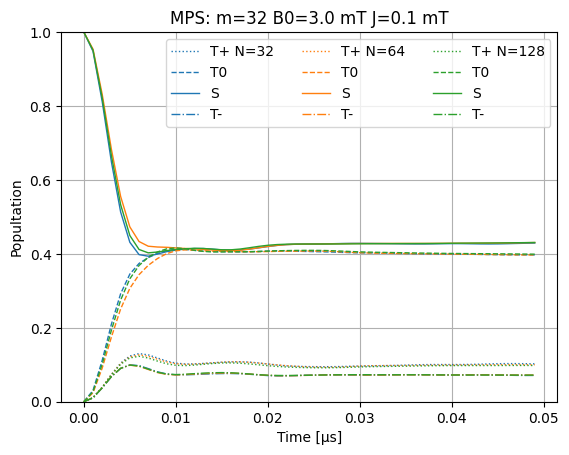

In [22]:
plt.clf()

for i, (density_data, color) in enumerate(
    zip(
        density_sums,
        plt.rcParams["axes.prop_cycle"].by_key()["color"],
        strict=False,
    )
):
    plt.plot(
        time_data_μs,
        density_data[:, 0, 0].real,
        linewidth=1,
        ls="dotted",
        color=color,
        label=f"T+ N={2 ** (i + 5)}",
    )
    plt.plot(
        time_data_μs,
        density_data[:, 1, 1].real,
        linewidth=1,
        ls="dashed",
        color=color,
        label="T0",
    )
    plt.plot(
        time_data_μs,
        density_data[:, 2, 2].real,
        linewidth=1,
        ls="solid",
        color=color,
        label="S",
    )
    plt.plot(
        time_data_μs,
        density_data[:, 3, 3].real,
        linewidth=1,
        ls="dashdot",
        color=color,
        label="T-",
    )
plt.title(f"MPS: {m=} {B0=} mT {J=} mT")
plt.legend(ncol=len(density_sums))
plt.xlabel("Time [μs]")
plt.ylabel("Popultation")
plt.grid()
plt.ylim([0, 1])
plt.savefig("population.png")
plt.show()

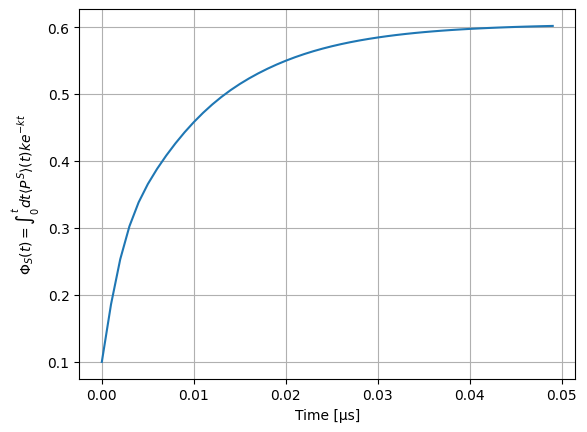

In [23]:
dt = time_data_μs[1] - time_data[0]
k_s = 1e2  # 1/micro sec, typically 1.0~0.1
phi_s = np.cumsum(
    density_data[:, 2, 2].real * dt * k_s * np.exp(-k_s * time_data_μs)
)

plt.plot(time_data_μs, phi_s)
plt.xlabel("Time [μs]")
plt.ylabel(r"$\Phi_S(t)=\int_0^t dt \langle P^S \rangle(t) ke^{-kt} $")
plt.grid()
plt.savefig("population.png")
plt.show()

Saving animation to rdm-radical.gif...
Animation saved successfully!


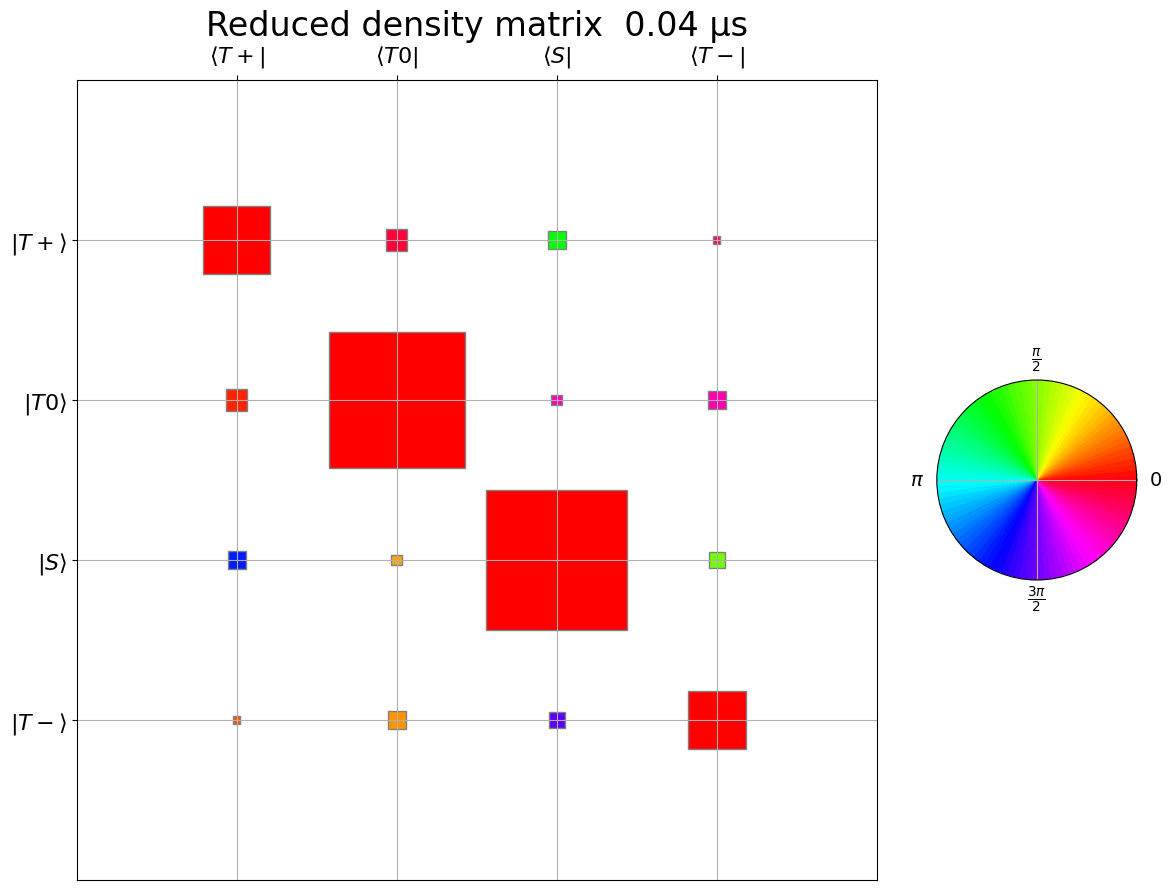

In [24]:
# Note: spin coherent state sampling has slower convergence for off-diagnal term than projection state sampling
fig, anim = get_anim(
    density_data[::10, :, :],
    time_data_μs[::10],
    title="Reduced density matrix",
    time_unit="μs",
    save_gif=True,
    dpi=30,
    gif_filename="rdm-radical.gif",
    row_names=[
        r"$|T+\rangle$",
        r"$|T0\rangle$",
        r"$|S\rangle$",
        r"$|T-\rangle$",
    ],
    col_names=[
        r"$\langle T+|$",
        r"$\langle T0|$",
        r"$\langle S|$",
        r"$\langle T-|$",
    ],
)
plt.show()
HTML(anim.to_jshtml())

## Compare with RadicalPy simulation

In [25]:
if len(basis) < 8:
    assert isinstance(D, np.ndarray)
    H = sim.total_hamiltonian(B0=B0, D=D, J=J)
    time = np.arange(0, 5e-8, 5e-10)
    rhos = sim.time_evolution(State.SINGLET, time, H)
    time_evol_s = sim.product_probability(State.SINGLET, rhos)
    time_evol_tp = sim.product_probability(State.TRIPLET_PLUS, rhos)
    time_evol_tz = sim.product_probability(State.TRIPLET_ZERO, rhos)
    time_evol_tm = sim.product_probability(State.TRIPLET_MINUS, rhos)
    x = time * 1e6

    plt.plot(x, time_evol_tp, linewidth=2, label="T+")
    plt.plot(x, time_evol_tz, linewidth=2, label="T0")
    plt.plot(x, time_evol_s, linewidth=2, label="S")
    plt.plot(x, time_evol_tm, linewidth=2, label="T-")
    plt.legend()
    plt.title(f"RadicalPy: Density Matrix Approach {B0=}, {J=}")
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel("Probability")
    plt.ylim([0, 1])
    plt.show()

In [26]:
if len(basis) < 6:
    fig, anim = get_anim(
        rhos[::, :, :],
        x[::],
        title="Full density matrix",
        time_unit="μs",
        dpi=30,
    )
    plt.show()
    display(HTML(anim.to_jshtml()))
elif len(basis) < 8:
    red_rhos = np.einsum(
        "tikjk->tij",
        rhos.reshape(
            rhos.shape[0], 4, rhos.shape[1] // 4, 4, rhos.shape[2] // 4
        ),
    )
    fig, anim = get_anim(
        red_rhos[::20, :, :],
        x[::20],
        title="Reduced density matrix",
        time_unit="μs",
        dpi=30,
    )
    plt.show()
    display(HTML(anim.to_jshtml()))

In [27]:
# Clean files
!rm -rf radicalpair_*_prop
!rm -f wf_radicalpair_*.pkl